<div style="background-color:powderblue;"><h1 align="center">Projet Synthese</h1>
    <p><b>Groupe 3: Amardeepkumar Haulkhory, Hilaire Yuma, Jian-Guo Zhao, Mamadou Sy</b></p>
</div>

<h2>Partie II Apprentissage par <abbr title="Convolutional Neural Networks"><b>CNN </b></abbr></h2>
<p>Definir le <abbr title="Convolutional Neural Networks"><b>CNN </b></abbr>architecture:</p>
<ol>
    <li>La premiere couche, Conv2D, prend un batch de données avec input_shape=(48, 48, 1)</li>
    <li>La deuxieme couche, Conv2D, prend la sortie de couche 1, keras determine le shape automatiquement</li>
    <li>Il n'est pas necessaire d'indiquer input_shape pour les couches plus profondes</li>
    <li>La troisième couche, Conv2D, prend la sortie de la couche 2, keras determine le shape automatiquement</li>
    <li>Ainsi de suite, on peut ajouter autres couches Conv2D s'il est nécessaire</li>
    <li>Entre chaque deux couches Conv2D, une couche Max pooling est ajoutée</li>
    <li>Pour reduire le sur-apprentissage, une couche de regularisation Dropout pourrait etre ajoutée</li>
    <li>Pour obtension d'une meilleure performance, une couche Normalisation pourrait etre aussi appliquée</li>
    <li>Avant la couche dense, nous ajoutons une couche Flatten qui convert le matrix 2D en vector 1D</li>
    <li>Puis, une couche Dense avec une fonction activation ReLu</li>
    <li>Encore une couche de regularization Dropout est appliquée avec une valeur plus grande normallement</li>
    <li>Enfin, la couche de sortie donne 7 neurons pour les 7 classes avec une fonction activation softmax qui donne la possibilité de prediction pour chaque class.</li>
</ol>

<h3><u>Dépendences - packages nécessaires</u></h3>
<p>En utilisant <b>tensorflow.compat.v1</b>, vous devez désactiver <b>eager_execution</b>.<br>Ce n'est pas le cas pour <b>tensorflow.v2</b>. De plus, le package <b>tensorflow</b> n'a pas la fonction <b><i>disable_eager_execution</i></b>.</p>
<hr>

In [1]:
import tensorflow as tf
#import tensorflow.compat.v1 as tf
#tf.disable_eager_execution()

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D 
from keras.utils import to_categorical

from keras.utils.data_utils import Sequence
#from imblearn.over_sampling import RandomOverSampler
#from imblearn.keras import balanced_batch_generator

import numpy as np      # linear algebra
import pandas as pd     # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from numpy import expand_dims
from keras.preprocessing.image import img_to_array

%matplotlib inline

Using TensorFlow backend.


<h3>Chargement des données</h3>
<p>Nous recommendons de télécharger les données <a href="https://www.kaggle.com/deadskull7/fer2013">fer2013</a> dans un répertoire local sur votre machine.<br>Ensuite inscrire le répertoire commme valeur de la variable <b>data_dir</b> ci-dessous.</p>

In [2]:
data_dir = 'C:\\GitHUB\\prosyn3_files\\fer2013.csv'
#"C:\\Users\\jeang\\Documents\\BDEB\\A62\\ProSyn3\\data\\fer2013.csv"
df = pd.read_csv(data_dir )

<h3>Répartition des données</h3>
<p>Les données originales sont réparties en trois parties. Selons Partie I, la cible est bien balancée dans ces trois parties</p>

In [3]:
df_training = df[df['Usage']=='Training']
df_validation = df[df['Usage']=='PublicTest']
df_test = df[df['Usage']=='PrivateTest']

<h3>Affichage des données</h3>
<p> Ces fonctions affichent un image (une ligne)<br>Notons que 48 x 48 = 2304</p>

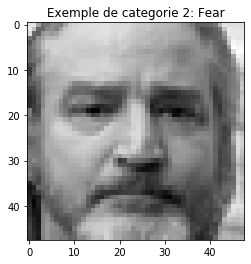

In [4]:
FER2013_WIDTH = 48
FER2013_HEIGHT = 48

# indices 0 - 6 correspondent emotions suivantes
Emotions = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]  

def string_to_image(str_in):
    return np.reshape(str_in.split(" "), (FER2013_WIDTH, FER2013_HEIGHT)).astype("float")

def fer2013_show_instance(index, d=df):
    """Shows the image and the emotion label of the index's instance."""
    category, str_image = d.at[index,'emotion'], d.at[index,'pixels']
    image = string_to_image(str_image)
    plt.imshow(image, cmap="gray")
    plt.title(f"Exemple de categorie {category}: {Emotions[category]}")
    
fer2013_show_instance(np.random.randint(0,len(df_training)))

<h3>Transformation des données</h3>
<p>La fonction <b><i>image_to_4d_array</i></b> prend comme entrée une dataframe contenant les données d'images en format des chaines de caractères.<br>Elle retoune comme sortie un array du genre <b>np.array</b> de <mark>4 dimensions</mark>, normalisée, x, et categoriel y, utilisables comme entrée pour <b>tensorflow CNN</b></p>

In [5]:
def image_to_4d_array(d=df, nclass=7):
    """Transforms the (blank separated) pixel strings in the DataFrame to an 4-dimensional array 
    (1st dim: instances, 2nd and 3rd dims represent 2D image, 4th dim represent the color)."""
    
    CLASS_NUMBER = min(nclass, 7)
    
    print("Converting pixels to 2D image ...")
    pixels_list = d["pixels"].values
    list_image_2d = [string_to_image(pixels) for pixels in pixels_list]
        
    # Convert list to 4D array:
    X = np.expand_dims(np.array(list_image_2d), -1)
    X = X / 255  
    
    print("Converting emotion to categorical n-array ...")
    Y = to_categorical(d.emotion, CLASS_NUMBER)
    
    print(f"The given dataset has been converted to {X.shape} array")
    
    return X, Y

<p>On applique la fonction <b><i>image_to_4d_array</i></b> sur les trois partitions</P>

In [6]:
X_train, Y_train = image_to_4d_array(df_training)
X_test, Y_test = image_to_4d_array(df_test)
X_valid, Y_valid = image_to_4d_array(df_validation)

Converting pixels to 2D image ...
Converting emotion to categorical n-array ...
The given dataset has been converted to (28709, 48, 48, 1) array
Converting pixels to 2D image ...
Converting emotion to categorical n-array ...
The given dataset has been converted to (3589, 48, 48, 1) array
Converting pixels to 2D image ...
Converting emotion to categorical n-array ...
The given dataset has been converted to (3589, 48, 48, 1) array


<h3>Fonction <i>get_model_v23</i></h3>
<ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>get_model_v23</i></b> peut prendre seulement quelques hyperparamètres</li>
<li>Elle appelle <i style="color:blue">keras.models.Sequential</i> qui nous permet de construire un modèle cnn</li>
<li>Les valeurs par défaut sont notre choix entre les meilleures, mais elle laisse des chances pour utilisateur de les choisir</li>
<li>Elle retourne un architecture d'un modèle sequential qu'on peut entrainer et tester</li>
</ul>

<hr>
<h4>Points essentiels de la fonction <i>get_model_v23</i></h4>
<ol>
<li>Nombre de couches est 5 par défaut, mais elle peut être un entier de votre choix</li>
<li>Les nombres de filtre doivent être en rapport avec le nombre de couche, de préference plus elevé pour les couches profondes.</li>
<li>Les kernel sizes doivent être en rapport avec le nombre de couches, de préference impaire et le plus petit que possible</li>
<li>Les pooling size doivent être en rapport avec le nombre de couches, de préference petit ou zéro </li>
<li>Les dropout values doivent être en rapport avec le nombre de couches.</li>
</ol>

In [7]:
def get_model_v23(num_layers=5, lf=256, ld=0.5,
                  num_filtre=(16, 32, 64, 128, 256), 
                  k_size=(3,3,3,3,3), 
                  p_size=(2,2,2,2,0), 
                  dropout=(0.10, 0.10, 0.15, 0.10, 0.10)):
    
    input_shape, num_classes, last_features, last_dropout = (48, 48, 1), 7, lf, ld
    
    model = Sequential()
    
    for layer in range(num_layers): 
        if layer == 0:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same", input_shape=input_shape))
        else:
            model.add(Conv2D(num_filtre[layer], kernel_size=k_size[layer], activation=tf.nn.relu, padding="same"))
            # normalization for each layer but not the first
            model.add(BatchNormalization())
        
        # max pooling with the given choose
        if p_size[layer] > 0:
            model.add(MaxPooling2D(pool_size=(p_size[layer], p_size[layer])))
        
        # Dropout with the given choose
        if dropout[layer] > 0:
            model.add(Dropout(dropout[layer]))           
        

    model.add(Flatten())                          
    model.add(Dense(last_features, activation=tf.nn.relu))
    model.add(Dropout(last_dropout))
    model.add(Dense(num_classes, activation=tf.nn.softmax))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

<h3>Fonction <i>save_model</i></h3>
<ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>save_model</i></b> prend un modèle sequentièle et le nom du fichier.</li>
<li>Elle appelle <i style="color:blue">keras.models.Sequential.to_json</i> et <i style="color:blue">save_weights</i></li>
</ul>

In [8]:
def save_model(model, file_json="", file_weight="", workdir=""):
    # serialize model to JSON
    model_json = model.to_json()
    projet_dir = workdir if len(workdir)>0 else 'C:\\GitHUB\\prosyn3_files'
    #"C:\\Users\\jeang\\Documents\\BDEB\\A62\\ProSyn3"
    model_filename = 'fer.json' if file_json=="" else file_json
    with open(os.path.join(projet_dir, model_filename), "w") as json_file:
        json_file.write(model_json)

    # serialize weights to HDF5
    # model.save_weights("C:\\Users\\Nisha Haulkhory\\projet de synthese\\GIT\\ProSyn3\\fer.h5")
    weight_filename = 'fer.h5' if file_weight=="" else file_weight
    model.save_weights(os.path.join(projet_dir, weight_filename))
    print("Saved model to disk done")

<h3>Fonction <i>show_confusion_matrix</i></h3>
<ul>
    <li>Cette fonction <b style="backgroud-color:powerblue"><i>show_confusion_matrix</i></b> prend comme entrée un modèle</li>
    <li>Elle appelle <i style="color:blue">model.predict</i> et le set de test pour <i>y_pred</i></li>
    <li>Elle compare <i>y_pred</i> avec les valeurs réelles pour construire la matrice de confusion.</li>
    <li>Elle normalize la matrice de confusion car les cibles dans nos données originales ne sont pas uniformes.</li>
    <li>Mais ceci pourrait déclencher des erreurs pour les classes manquantes car Div_by_zero donne NA</li>
</ul>

In [9]:
def show_confusion_matrix(model, x_test=X_test, y=df_test.emotion):
    submission = pd.DataFrame(model.predict(x_test))
    submission['label'] = submission.idxmax(axis=1)
    cm = confusion_matrix(submission['label'], y)               # df_test['emotion'])
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = cm.round(2)
    return pd.DataFrame(cm)

<h3>Class <i>BalancedDataGenerator</i></h3>
<p>
Cette classe <b style="backgroud-color:powerblue"><i>BalancedDataGenerator</i></b> est trouvée sur web pour imbalanced dataset.<br>Pour en savoir plus sur <b>Keras ImageDataGenerator and Data Augmentation</b><a href="https://gist.github.com/arnaldog12/16efc663c869b35e2479bd607d56c1da"> Cliquer ici.</a>
<br>Elle selecte non uniformement les échantillons pour les augmenter et finir avec relativement un dataset uniform.</p>


In [10]:
class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)  
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, 
                                                                  sampler=RandomOverSampler(), 
                                                                  batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

<h3>Objet <i>ImageDataGenerator</i></h3>
<p>Cette instance d'objet <b style="backgroud-color:powerblue"><i>datagen</i></b> est utilisable dans plusieurs cas pour l 'augmentation des données.</p>

In [11]:
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=20,
                             width_shift_range=0.15,
                             height_shift_range=0.15,
                             shear_range=0.15,
                             zoom_range=0.15,
                             horizontal_flip=True,
                             vertical_flip=False)

# bgen = BalancedDataGenerator(X_train, Y_train, datagen, batch_size=256)
# steps_per_epoch = bgen.steps_per_epoch

<h3>Fonction <i>uniform_data_aug_fit</i></h3>
<p><ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>uniform_data_aug_fit</i></b> prend comme entrées:
<ol><li>un modèle à apprendre</li>
<li>une instance ImageDataGenerator</li>
<li>le set d'apprentissage,</li>
<li>le set de validation.</li>
<li>et la taille du batch bs</li></ol></li>
<li>Elle calcule le nombre de <i style="color:blue">steps_per_epoch</i> pour contrôler le trade-off temps et performance</li>
<li>La différence est qu'elle n'utilise pas le même taux d' augmentation, mais plus grand pour les classes moins populaires</li>
<li>Elle appelle la fonction <i style="color:blue">model.fit_generator</i> pour entraîner le modèle.</li>
</ul></p>

In [12]:
def uniform_data_aug_fit(model, dgen, x_train, y_train, valid, bs, taux=9, ep=10):
    taux_augmented_data = min(taux, 48)  
    batch_size = min(bs, x_train.shape[0])
    steps_per_epoch = int(x_train.shape[0] * taux_augmented_data / batch_size)
    l = model.fit_generator(dgen.flow(x_train, y_train, batch_size=batch_size), epochs=ep, validation_data=valid,
                            verbose = 1, steps_per_epoch = steps_per_epoch)
    return model, l

<h3>Fonction <i>balance_fit</i></h3>
<ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>balance_fit</i></b> prend un modèle et une instance ImageDataGenerator</li>
<li>Elle appelle la fonction <i style="color:blue">uniform_data_aug_fit</i> pour faire apprendre le modèle</li>
<li>La difference est qu'elle n'utilise pas le même taux d'augmentation, plus grand pour les classes moins populaires</li>
<li>En effet, elle entraine 3 fois le modèle avec 3 training set differents </li>
</ul>
<p><b>Noter</b> dans certain cas les columns de l.history sont <i>['acc', 'val_acc']</i> dans d autres cas <i>['accuracy', 'val_accuracy']</i><br>Si vous avez des erreurs lorsque la fonction ci-dessous est appelé c'est probablement à cause de ces columns.</p>

In [13]:
def balance_fit(model, dgen, valid=(X_valid, Y_valid), bs=32, ep=10, fnm='fer.json', fnw='fer.h5'):
    
    #train the model with uniform_data_aug_fit but the trainset without the most popular calss 3
    train_o = df_training[(df_training.emotion != 3)]
    valid_o = df_validation[(df_validation.emotion != 3)]
    test_o = df_test[(df_test.emotion != 3)]
    
    x, y = image_to_4d_array(train_o)
    validation = image_to_4d_array(valid_o)
    x_test, y_test = image_to_4d_array(test_o)
    
    model, l = uniform_data_aug_fit(model, dgen, x, y, validation, bs, taux=12, ep=ep)
    show_confusion_matrix(model, x_test=x_test, y=test_o.emotion)
    sns.lineplot(data=pd.DataFrame(l.history)[['acc','val_acc']], palette="tab10", linewidth=2.5);
    print("Evaluating the model on test data ...")
    results = model.evaluate(x_test, y_test)
    print("test loss, test acc:", results)
    
    # second train the model with all train set, validation set and test set without data augmentation
    l = model.fit(x=X_train, y=Y_train, validation_data=valid, batch_size=256, epochs=ep)
        
    return l 

<h3>Fonction <i>show_save_trained_model</i></h3>
<ul>
<li>Apres avoir entraîné un modèle, nous voulons souvent savoir l'historique d'apprentissage, la performance, et sauvegarder le modèle</li>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>show_save_trained_model</i></b> donne une flexibilité pour differentes méthodes d'apprentissage</li>
<li>Elle prend le modèle et l'historique d'apprentissage en entrées</li>
<li>Elle compare avec les set de test pour évaluer le modèle.</li>
<li>Elle imprine aussi la matrice de confusion </li>
</ul>
<p><b>Noter</b> dans certain cas les columns de l.history sont <i>['acc', 'val_acc']</i> dans d autres cas <i>['accuracy', 'val_accuracy']</i><br>Si vous avez des erreurs lorsque la fonction ci-dessous est appelé c'est probablement à cause de ces columns.</p>

In [14]:
def show_save_trained_model(model, history, fnm, fnw, x_test=X_test, y_test=Y_test, y=df_test.emotion):
    sns.lineplot(data=pd.DataFrame(history.history)[['acc','val_acc']], palette="tab10", linewidth=2.5);
    save_model(model, file_json=fnm, file_weight=fnw)
    print("Evaluating the model on test data ...")
    results = model.evaluate(x_test, y_test)
    print("test loss, test acc:", results)
    print(show_confusion_matrix(model, x_test, y))

<h3>Fonction <i>fit_test_save_model</i></h3>
<ul>
<li>Cette fonction <b style="backgroud-color:powerblue"><i>fit_test_save_model</i></b> regroupe plusieurs commandes</li>
<li>Elle fournie une interface pour l'apprentissage, l'évaluation, la visualisation, et la sauvegarde du modèle cnn.</li>
<li>Si le drapeau <b style="backgroud-color:powerblue"><i>aug</i></b> est Faux, elle apprend le modèle avec le set d apprentissage et le set de validation.</li>
<li>Si le drapeau <b style="backgroud-color:powerblue"><i>aug</i></b> est True, elle apprend le modèle avec le set d'apprentissage augmenté.</li>
<li>Une fois l'apprentissage se termine, elle execute des commandes pour afficher l'historique d'apprentissage, sauvegarder le modèle.</li>
</ul>

In [15]:
def fit_test_save_model(model, x_train=X_train, y_train=Y_train, valid=(X_valid, Y_valid), 
                        aug=True, imbalance=False, dgen = datagen,
                        bs=32, ep=10, fnm='fer.json', fnw='fer.h5'):
    
    print("Fitting the model ...")
    batch_size = min(bs, x_train.shape[0])
    
    if not aug:
        print("Augementation")
        l = model.fit(x=x_train, y=y_train, validation_data=valid, batch_size=batch_size, epochs=ep)
        
    elif imbalance:
        print("Imbalance")
        # I prefer balance_fit because I know how it works
        l = balance_fit(model, dgen, valid, bs=batch_size, ep=ep)
        
        # I tried this method but I did not get reasonable result: There are something wrong
        # bgen = BalancedDataGenerator(x_train, y_train, dgen, batch_size=batch_size)
        # steps_per_epoch = bgen.steps_per_epoch
        # l = model.fit_generator(bgen, steps_per_epoch, epochs=ep, validation_data=valid, verbose = 1)
    
    else:
        print("Other")
        _, l = uniform_data_aug_fit(model, dgen, x_train, y_train, taux=9, bs=batch_size, ep=ep, valid=valid)

    show_save_trained_model(model, l, fnm, fnw)
    
    return l

<h3>1er exemple de construction de CNN model</h3>
<p>Par defaut, il y a 5 couches conv2D, la taille k_size est (3,3) pour chaque couche</p>
<p>Notons que les valeurs dropout sont 0.1 pour ces 5 couches, mais last_dropout(ld) est 0.45</p>

In [16]:
#Same architecture will used for 3nd eample
model = get_model_v23(num_filtre=(16, 32, 64, 128, 256), lf=256, ld=0.45, p_size=(2,2,2,2,0), dropout=(0.1, 0.1, 0.1, 0.1, 0.1))
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 24, 24, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
___________________

In [ ]:
l = fit_test_save_model(model, bs=32, ep=25, fnm='fer238.json', fnw='fer238.h5')

<h4>Commentaires</h4>
<p>Tant qu'il n'y a pas de sur-apprentissage, un modèle peut être continuellement entraîné jusqu'à la performance desiré. Ceci est vrai au moins sur le même set d'apprentissage.<br> Nous constatons que <i>l'accuracy</i> s'améliore dans chaque epoch, et que <i>val_accuracy</i> a aussi une tendance d'augmenter. Dans chaque epoch, il y a 8074 steps, ceci est definie par la taille de notre set d'apprentissage, le taux d'augmentation, et la batch_size (28709*9/32).<br>Notons que ce nombre d' étapes doit être assez élevé pour un meilleur apprentssage. Mais le temps d'apprentissage augmente aussi rapidement avec ce nombre. Par exemple l'execution de la commande ci-dessus a pris environ 14000 secondes, ou 3.89 heurs.(Ceci est variable selon le type de machine sur laquelle est executé ce code.)</p>
<p>Effet nombre filtres: forte nombre filtre est préferable pour chercher features, mais non favorable pour overfitting. Non plus pour le temps d'apprentissage. Le plus important, mettre le nombre de filtre plus elevé dans les couches profondes. Ceci est favorable pour réduire le temps d'apprentissage.</p>
<p>Effet dropout: forte dropout est préferable pour contrôler overfitting, mais non favorable pour ralentir la vitesse d'apprentissage. C'est un trade-off dans l'apprentissage par CNN</p>
<p>Meilleur performance obtenu avec le set de test avant était de 64.5% lorsque le dropout=(0.1,0.1,0.1,0.1,0.1), ld=0.35, ep=10. Avec les condition ci-dessus, nous avons eu une meilleure performance: <b>66%</b></p>
<hr>
<h3>Proposition nouveau essai</h3>
<p>Pouvons-nous entraîner un modèle avec different set d'appretissage? Si l'apprentissage du modèle s'améliore continuellement malgré le changement du set d'apprentissage, nous pouvons traiter le problème imbalance de notre set d'apprentissage. En effet, la classe la plus populaire <b>happy(3)</b> a une performance d'environ 91% mais la classe <b>sad(4)</b> a seulement 44% selon un matrice de confusion.<br>Si, au lieu d'augmenter tous train set 9 fois, on augmente seulement 12 fois les autre classes moins populaires, on pourrait sauve du temps d'apprentissage.<br>
En basant sur cette proposition, nous allons traiter notre défi d'over-fitting et unbalanced dataset ci-dessous.<br>En 3ième exemple, nous allons reprendre cette technique.</p>

In [ ]:
model = get_model_v23(num_filtre=(16, 32, 64, 128, 256), lf=256, ld=0.5, p_size=(2,2,2,2,0), dropout=(0.1, 0.1, 0.1, 0.1, 0.1))
model.summary()

<div><p><b>Noter</b> dans certain cas les columns de l.history sont <i>['acc', 'val_acc']</i> dans d autres cas <i>['accuracy', 'val_accuracy']</i><br>Si vous avez des erreurs lorsque la fonction ci-dessous est appelé c'est probablement à cause de ces columns.</p></div>

In [ ]:
train_o = df_training[(df_training.emotion != 3)]
valid_o = df_validation[(df_validation.emotion != 3)]
test_o = df_test[(df_test.emotion != 3)]
    
x, y = image_to_4d_array(train_o)
validation = image_to_4d_array(valid_o)
x_test, y_test = image_to_4d_array(test_o)
    
model, l = uniform_data_aug_fit(model, datagen, x, y, valid=validation, bs=32, taux=9, ep=10)
show_confusion_matrix(model, x_test=x_test, y=test_o.emotion)
sns.lineplot(data=pd.DataFrame(l.history)[['acc','val_acc']], palette="tab10", linewidth=2.5);
print("Evaluating the model on test data ...")
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

In [ ]:
# Pour corriger les erreur ci-haute
show_confusion_matrix(model, x_test=x_test, y=test_o.emotion)

<div><p><b>Noter</b> dans certain cas les columns de l.history sont <i>['acc', 'val_acc']</i> dans d autres cas <i>['accuracy', 'val_accuracy']</i><br>Si vous avez des erreurs lorsque la fonction ci-dessous est appelé c'est probablement à cause de ces columns.</p></div>

In [ ]:
# Pour corriger les erreur ci-haute
sns.lineplot(data=pd.DataFrame(l.history)[['acc','val_acc']], palette="tab10", linewidth=2.5);

In [ ]:
# Pour corriger les erreur ci-haute
results = model.evaluate(x_test, y_test)
print("test loss, test acc:", results)

<div><p><b>Noter</b> dans certain cas les columns de l.history sont <i>['acc', 'val_acc']</i> dans d autres cas <i>['accuracy', 'val_accuracy']</i><br>Si vous avez des erreurs lorsque la fonction ci-dessous est appelé c'est probablement à cause de ces columns.</p></div>

In [ ]:
# Not sure if these data are overwriten
#x, y = image_to_4d_array(df_training)
#validation = image_to_4d_array(df_validation)
#x_test, y_test = image_to_4d_array(df_test)

#X_train, Y_train = image_to_4d_array(df_training)
#X_test, Y_test = image_to_4d_array(df_test)
#X_valid, Y_valid = image_to_4d_array(df_validation)

l = model.fit(x=X_train, y=Y_train, validation_data=(X_valid, Y_valid), batch_size=256, epochs=30)    
#model, l = uniform_data_aug_fit(model, datagen, x, y, valid=validation, bs=32, taux=9, ep=10)
show_confusion_matrix(model, x_test=X_test, y=df_test.emotion)
sns.lineplot(data=pd.DataFrame(l.history)[['acc','val_acc']], palette="tab10", linewidth=2.5);
print("Evaluating the model on test data ...")
results = model.evaluate(X_test, Y_test)
print("test loss, test acc:", results)


In [ ]:
show_confusion_matrix(model, x_test=X_test, y=df_test.emotion)

<h4>Commentaires sur 2ième apprentissage avec différent set d'apprentissage.</h4>
<p>Eventuellement, le changement de data-set pour 2ième apprentissage d'un modele semble être une technique positive. Pour apprendre d'un modèle vierge par <i>uniform_data_augmentation</i>, on a besoin d'environ 14000 (570x25) seconds pour une performance de 64%.</p>
<p>Avec un apprentissage par <i>uniform_data_augmentation</i> sur les autres classes que la plus populaire puis un 2ième apprentissage sans data_augmentation, on a besoin d'environ 5900 (430x10+54X30) seconds pour une performance similaire. Un économie de plus que 50%.</p>
<hr>
<h3>2ième exemple de construction de CNN model</h3>
<p>Par défaut, il y a 5 couches, la taille k_size est (3,3) pour chaque couche.<br>
    <b>Notons que les valeurs dropout sont 0.25 pour ces 5 couches, et last_dropout(ld) est 0.5</b></p>

In [ ]:
model = get_model_v23(num_filtre=(16, 32, 64, 128, 256), lf=256, ld=0.5, p_size=(2,2,2,2,0), dropout=(0.25, 0.25, 0.25, 0.25, 0.25))
model.summary()

<h3>2ième exemple d'apprendre d'un CNN model</h3>
<p>Cette fois, la technique d'augmentation de données (Data Augmentation) n'est pas utilisée.</p>

In [ ]:
l = fit_test_save_model(model, bs=256, ep=50, aug=False, fnm='fer234.json', fnw='fer234.h5')

<h4>Commentaires</h4>
<p>Nous observons un sur-apprentissage malgré une forte 'dropout'. Une performance de 62.7% est obtenue sans l'augmentation des données. Le temps d'apprentissage est relativement courte: environ 2700s (54x50)</p>

<h3>3ième exemple d'apprendre un CNN model</h3>
<p>Cette fois-ci, nous avons utilisé une technique de deux entraînements sequentiels.Cependant <i>"imbalanced data augmentation"</i> est utilisé pendant le premier entraînement uniquement.</p>

In [ ]:
model = get_model_v23(num_filtre=(16, 32, 64, 128, 256), lf=256, ld=0.45, p_size=(2,2,2,2,0), dropout=(0.1, 0.1, 0.1, 0.1, 0.1))
model.summary()

In [ ]:
l = fit_test_save_model(model, bs=32, ep=10, imbalance=True, fnm='fer235.json', fnw='fer235.h5')

<h4>Commentaires</h4>
<p>Nous observons d'over-fitting seulement pour la deuxième entraînement malgré faible dropout. Une performance de 63.9% est obtenue qui est de même que uniform data augmentation. Le temps d'apprentissage est relativement courte, environ 6000s (555+51)x10. </p>
<hr>
<h2>Conclusion</h2>
<ul>
<li>L'interface de construction du model cnn et de l'apprentissage devient simplement deux appels de deux fonctions.</li>
<li>Par choix des hyperparametres, on peut avoir differents modèles et la technique d'apprentissage.</li>
<li>Sans data augmentation, maximum accuracy sur set de test est 62% en ce moment. Ce n'est pas le plus haute.</li>
<li>De plus, sans data augmentation, forte dropout sont nécessaires pour lutter contre le sur-apprentissage.</li>
<li>Avec data augmentation, nous obtenous de meilleurs performance: 66% dans le cas keras.ImageDataGenerator.</li>
<li>Avec cette technique, faible valeurs dropout sont suffisant pour empêcher un overfitting.</li>
<li>mais le temps d'apprentissage est relativement longue.</li>
<li>Pour réduire le temps d'apprentissage, nous avons utilisé une technique telle que seul les classes qui sont difficiles à classifier ont eu une data augmentation, le modele est ensuite entrainé par la même technique sans data augmentation. Nous avons eu une performance aussi elevée que 64% mais le temps d'apprentissage est réduit à plus que 50% (6060/14600)</li>
<li>Avec une technique oversampling, Nous n'avons pas eu de bon résultat, faut du temps serré et manque de compréhension de cette technique. Voir les cellules qui suivent la conclusion</li>
</ul>
<hr>
<h2>Annexe</h2>
<p>Noté sur une mauvaise expérience avec une classe <b><i style="color:blue">BalancedDataGenerator</i></b></p>
<hr>
<h3>3ième exemple de construction du CNN model</h3>
<p>Par défaut, il y a 5 couches, la taille k_size est (3,3) pour chaque couche.<br>
Notons que les valeurs dropout sont 0.1 pour les 5 couches, mais last_dropout(ld) est 0.45. Cette architecture a été utilisée pour la premier exemple</p>
<hr>

In [ ]:
model = get_model_v23(num_filtre=(16, 32, 64, 128, 256), lf=256, ld=0.45, p_size=(2,2,2,2,0), dropout=(0.1, 0.1, 0.1, 0.1, 0.1))
model.summary()

<h3>3ième Exemple d'apprendre un CNN model</h3>
<p>Cette fois, la technique de imbalanced data augmentation est utilisée</p>

In [ ]:
l = fit_test_save_model(model, bs=32, ep=10, imbalance=True, fnm='fer235.json', fnw='fer235.h5')

In [ ]:
datagen = ImageDataGenerator(featurewise_center=False,
                             featurewise_std_normalization=False,
                             rotation_range=45,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=.2,
                             horizontal_flip=True,
                             vertical_flip=True)

#bgen = BalancedDataGenerator(X_train, Y_train, datagen, batch_size=256)
#steps_per_epoch = bgen.steps_per_epoch

<h2> Réferences </h2>
<p>pour en savoir plus sur <a href="https://keras.io/api/preprocessing/image/">keras image data generator class</a><br>
Que ce que c'est <a href="https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb">Imbalanced Data</a><br>
Pour savoir comment traiter <b>"Imbalanced image data"</b> <a href="https://medium.com/analytics-vidhya/how-to-apply-data-augmentation-to-deal-with-unbalanced-datasets-in-20-lines-of-code-ada8521320c9">Cliquer ici.</a><br>
<a href="https://github.com/scikit-learn-contrib/imbalanced-learn">Code original</a> pour <b>"Imbalanced image data"</b></p>
<p>En utilisant <b>ImageDataGenerator</b> avec Keras, nous obtenons des données additionnelles d'apprentissage.De ce fait, vous pourriez initialiser le nombre d'exemplaire  pour l'apprentissage par vous même, par exemple si vous voulez doubler les données d'apprentissage il suffit d'appliquer la formule <b>steps_per_epoch as (original_sample_size*2)/batch_size.</b>.  Pour plus d'infos <a href="https://stackoverflow.com/questions/47928347/value-of-steps-per-epoch-passed-to-keras-fit-generator-function"> cliquez ici </a>.</p>